# Experiments for Regression using synthetic datasets

In [1]:
#Utilities
import numpy as np 

def rademacher_variables(vec_size):
    if vec_size % 2 != 0:
        return("Error, vector size should be even.")
    s = np.random.binomial(1,0.5, vec_size)
    a = sum(s)
    while a.all() !=0:
        s = np.random.binomial(1,0.5, vec_size)
        s[s < 1] = -1
        a = sum(s)
    return(s)

    
def rademacher_bound(dim_x, dim_y, array_x, delta, train_error, array_Rademacher):
    bound = np.zeros([dim_x,dim_y])
    c =3*(np.sqrt(np.log(2/delta))/(2*(array_x)))
    for i in range(0,dim_x):
        bound[i] = np.add(train_error[i], array_Rademacher[i])
        bound[i] = np.add(bound[i],c)
    return(bound)

def vc_dimension_regression(dim_x, dim_y, array_x, array_Rademacher):
    VC = np.zeros([dim_x,dim_y])
    c = array_x/(2*np.log(array_x))
    for i in range(0,dim_x):
        VC[i] = (array_Rademacher[i]**2)*c
    return(VC)

def VC_bound(dim_x, dim_y, array_x, train_error, array_VCdim, delta):
    VCbound = np.zeros([dim_x,dim_y])
    a = array_VCdim/array_x #VC/#samples
    b = np.log(array_x/array_VCdim)
    b = np.where(b > 0, b, 10**(-8))
    c = np.log(delta/4)
    for i in range(0,dim_x):
        VCbound[i] = train_error[i]/abs((1-0.1*np.sqrt(a[i]+a[i]*b[i]-c)))
    return(VCbound)


## Experiment 1:  Evaluating how train and test error varies with increasing training set size.

<br>Empirical train and test error: Root Mean Squared Error 
<br>Theoretical Bounds: Rademacher and VC Bounds for Regression 

Hyperparameters: 
<br>Additive noise from normal distribution with std = 0.2
<br>Test Samples = 30
<br>Train Samples = [6,16,32,42,....,196]
<br>We run each sample size 100 times and take the average for calculating the empirical erros to reduce noise. 


In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt

n = range(6,200, 10)
n_2 = range(0,100,1)
f = 2 # frequency for sin signal


test_error = np.zeros([3,len(n)])
train_error = np.zeros([3,len(n)])
temp_test = np.zeros([3,len(n_2)])
temp_train = np.zeros([3,len(n_2)])
temp_L = np.zeros([3,len(n_2)])
Rad = np.zeros([3,len(n)])

#step 1 - data generation
#Test set
n_test = 30
X_test = np.vstack([[np.random.uniform(0,1,n_test).reshape(-1,1)],         
               [np.random.uniform(0,1,n_test).reshape(-1,1)],
               [np.arange(n_test).reshape(-1,1)]])
e = np.random.normal(0,0.2,n_test).reshape(-1,1)
Y_test = np.vstack([[(10.5*X_test[0] +5 + e).reshape(-1,1)], #linear
              [(10.5*X_test[1] + 90*X_test[1]**2 +5 + e).reshape(-1,1)], #quadratic
               [np.sin(2*np.pi*f*(X_test[2]/n_test)+ 5*e).reshape(-1,1)]]) #sin increased noise to avoid better prediction when #samples train  ~=  #samples test

for counter,value in enumerate(n): 
    for j in n_2:
        #Train set
        fs = value #sample rate for sin signal
        X_train = np.vstack([[np.random.uniform(0,1,value).reshape(-1,1)],         
                       [np.random.uniform(0,1,value).reshape(-1,1)],
                       [np.arange(fs).reshape(-1,1)]])
        e = np.random.normal(0,0.2,value).reshape(-1,1)
        Y_train = np.vstack([[(10.5*X_train[0] +5 + e).reshape(-1,1)],
                      [(10.5*X_train[1] + 90*X_train[1]**2 +5 + e).reshape(-1,1)],
                       [np.sin(2*np.pi*f*(X_train[2]/fs)+ 5*e).reshape(-1,1)]])
        
        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
    
        #rademacher sigma
        s = rademacher_variables(int(Y_train[0].shape[0]))

        for i in range(0,3,1):
            
            #Step 2: model fitting
            #initialisation of linear regression model
            m = LinearRegression()

            #inserting train data into model for training
            m.fit(X_train[i],Y_train[i])

            #predicting values for test data
            Y_pred_test[i] = m.predict(X_test[i])
            Y_pred_train[i] = m.predict(X_train[i])

            #computing RMSE
            error_test= np.sqrt(mean_squared_error(Y_test[i], Y_pred_test[i]))
            temp_test[i,j] =  error_test

            error_train= np.sqrt(mean_squared_error(Y_train[i], Y_pred_train[i]))
            temp_train[i,j] = error_train
            
             #Rademacher constant      
            temp_L[i,j] = 2*np.dot(s, np.sqrt((Y_train[i]-Y_pred_train[i])**2))/len(Y_train[i])
    
    test_error[:,counter] = np.mean(temp_test, axis = 1)
    train_error[:,counter] = np.mean(temp_train, axis = 1)
    Rad[:,counter] = np.amax(temp_L, axis = 1) 

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound(3, len(n), np.array(n), 0.1, train_error, Rad)
print("Rademacher Bound")
print(radBound)
VCdim = vc_dimension_regression(3, len(n), np.array(n), Rad)
print("VC Dimension")
print(VCdim)
VCBound = VC_bound(3, len(n), np.array(n), train_error, VCdim, 0.1)
print("VC Bound")
print(VCBound)

Rademacher Constant
[[0.20597834 0.18344687 0.08578615 0.10934477 0.11385156 0.0750398
  0.05630358 0.08391438 0.06378426 0.05921998 0.05145777 0.04840429
  0.05997302 0.05304169 0.05120861 0.05094461 0.03832723 0.03644007
  0.04691443 0.03797659]
 [5.92622321 4.49482928 2.98175847 3.42052863 2.57591912 2.99128505
  1.62686189 1.90877824 1.74784515 1.46691023 1.68196358 1.60536263
  1.22883601 1.61951048 1.35674966 1.48930806 1.22080943 1.18287242
  1.06937527 1.36188346]
 [0.49139088 0.44143833 0.32979884 0.20262385 0.25714712 0.20913273
  0.17700424 0.14958824 0.16516591 0.13809789 0.20778346 0.1947681
  0.12969188 0.08090881 0.13771236 0.10819084 0.12893555 0.10595878
  0.12389532 0.0868591 ]]
Rademacher Bound
[[ 0.79049493  0.53227325  0.37483231  0.37817011  0.36504512  0.31619603
   0.2907177   0.31360406  0.29220453  0.28523855  0.27379519  0.26781519
   0.27812959  0.27096986  0.26548476  0.26551619  0.25316971  0.25078974
   0.25931491  0.24888128]
 [10.8360376  10.72265056  9

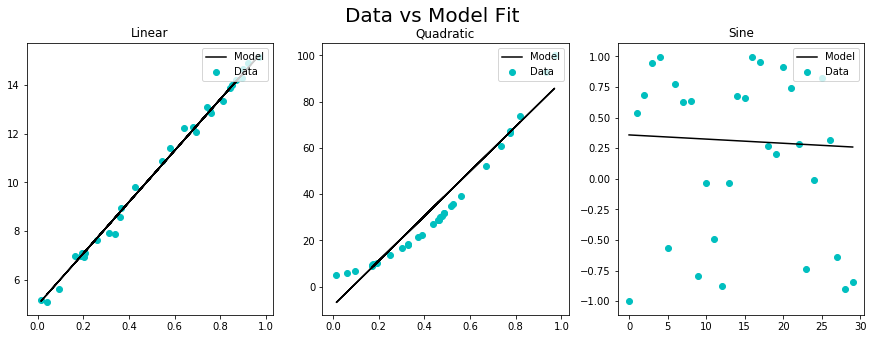

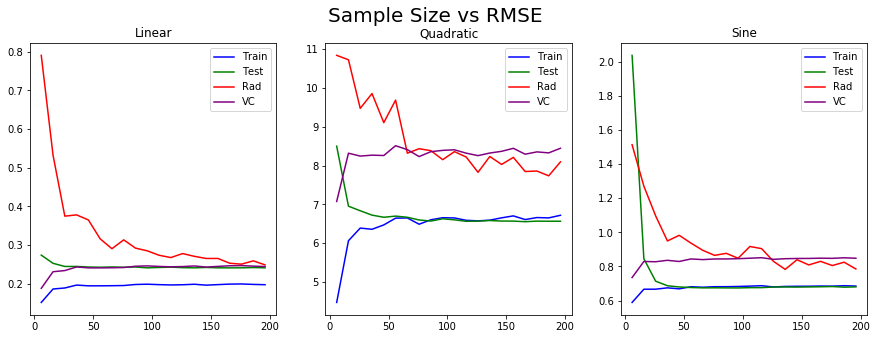

In [15]:
#Step 3: Evaluation

import matplotlib.pyplot as plt

funcs = ["Linear", "Quadratic", "Sine"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Data vs Model Fit', fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].scatter(X_test[i],Y_test[i],color='c', label = 'Data')
    axes[i].plot(X_test[i], Y_pred_test[i], color = 'black', label = 'Model') 
    axes[i].legend(loc='upper right')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Sample Size vs RMSE',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].plot(n,train_error[i],color='blue', label = 'Train')
    axes[i].plot(n,test_error[i],color = 'green', label = 'Test')
    axes[i].plot(n,radBound[i], color = 'red', label = 'Rad')
    axes[i].plot(n, VCBound[i], color = 'purple', label = 'VC')
    axes[i].legend(loc='upper right')
plt.show()

In [16]:
#Step 4: Symbolic Regression (finding closed formula for test error depending only on sample size)
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

# Create custom operations (exp) to be considered in the tree
def _xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add','mul', 'div', 'log', 'sqrt', 'neg', xexp]

#fitting sumbolic regressor
est_gp = SymbolicRegressor(population_size=1000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.2, random_state=0,
                           function_set = f_set)

sample = []
for i in n: 
    sample.append(i)  
sample = np.array([sample])

for i in range(0,3):
    est_gp.fit(sample.reshape(-1,1), 100*test_error[i])
    print(est_gp._program)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.73      2.35547e+15        9          3.11393          2.22453     11.78s
   1    10.41      8.50767e+09        9         0.675637         0.957423      9.31s
   2     9.32      6.19908e+09       16         0.502627          2.55372      7.85s
   3     8.78      8.57632e+08       17         0.373407        0.0671586      7.91s
   4     8.19      1.23359e+09       11         0.349521          1.99783      6.93s
   5     7.82      7.22772e+08       13         0.356781          2.49423      6.96s
   6     7.82      4.99876e+08       13         0.410103          2.01434      6.56s
   7     8.02       3.9294e+08       13         0.412159          1.99583      5.68s
   8     8.00      3.33289e+08       13         0.402206          2.08541  

c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   4    33.75      3.42445e+12       63          51.2758          129.113     13.12s
   5    35.62      6.03902e+12       38          17.5188          425.066     11.39s
   6    31.84      5.29231e+11       76          17.2524          435.296     10.62s
   7    33.04      2.12395e+12       18          9.59764          417.352      9.57s
   8    38.40      5.86129e+10       19           10.269           97.213     10.70s
   9    39.15      1.98092e+11       40           10.269           97.213     10.25s
  10    36.16       1.5455e+11       54          8.40701          103.263      8.87s
  11    34.81      7.61567e+10       49          8.40701          356.157      7.77s
  12    31.91      4.39127e+11       64           9.2424          304.382      6.83s
  13    28.12      2.73337e+10       29          9.17842          257.406      4.61s
  14    24.64      3.05463e+09       34          7.49803          92.1294      4.17s
  15    22.23      1.05681e+10       17          6.32155         

RMSE (test_error x symbolic regressor)
4.999837880883821e-06
0.02864729572135429
0.024525124580919634


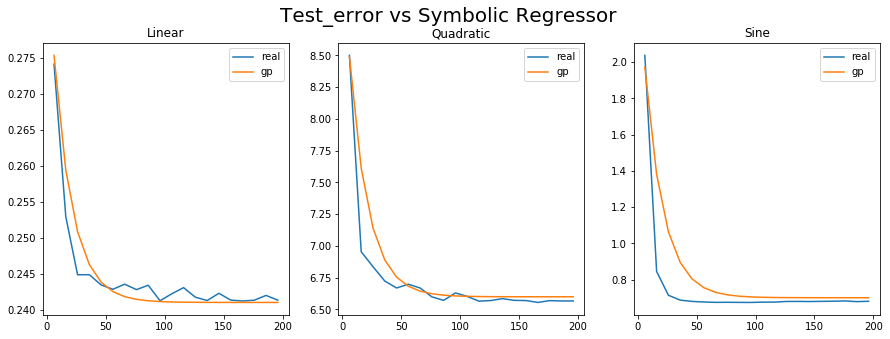

In [20]:
#Step 5: Evaluation for Symbolic Regressor
a1 = np.array([[0.05], [2.75], [1.85]])
a2 = np.array([[0.241], [6.6], [0.7]])

print("RMSE (test_error x symbolic regressor)")
y = np.zeros([3,sample.shape[1]])
for i in range(0,3):
    y[i] = ((np.sqrt(np.sqrt(np.sqrt(np.sqrt(np.exp(-sample))))))*a1[i])+a2[i]
    print(mean_squared_error(test_error[i], y[i].reshape(-1,1)))

funcs = ["Linear", "Quadratic", "Sine"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Test_error vs Symbolic Regressor',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].plot(sample.reshape(-1,1),test_error[i], label = 'real')
    axes[i].plot(sample.reshape(-1,1),y[i].reshape(-1,1), label = 'gp')
    axes[i].legend(loc='upper right')
plt.show()


### Conclusions experiment 1: 
**Theoretical expectations for Empirical Error Estimation:**

Train and test error curves should coverge. (ok);
<br>Test error decreases as sample size increases until reaching irreducible error. (ok);
<br>Train error increases as samples size increases until reaching a value close to the irreducible error for test. (ok);
<br>Theoretical bounds should upper bound test error curve (does not occur for training set < 25 samples for most samples, then both bounds indeed upper bound). 
<br>Observed: VC bound follows a lot the pattern of the training error with some bias in the y direction. Rademacher bound showed to be less tight than the VC bound for this experiment. 

<br>**Symbolic Regression Results:**

Found a closed-form expression for test error when varying sample size which is common for all datasets (linear, quadratic and sine): 

$$ (c*\sqrt[16]{e^{-n}}+b) $$

<br>c and b are hyperpameters that should be set by the user. c controls the range in y-direction and b control the minimal high of the shape (usually the value of the irreducible error is a good value for b).
<br>MSE(empirical test error, symbolic regressor expression) < 0.05 for all datasets. 

## Experiment 2:  Evaluating how train and test error varies with increasing model capacity
Empirical train and test error: Root Mean Squared Error 
<br>Theoretical Bounds: Rademacher and VC Bounds for Regression 

Hyperparameters: 
<br>Additive noise from normal distribution with std = 0.2
<br>Test Samples = 20
<br>Train Samples = 30
<br>Varying model capacity by adding polynomials with degrees = [1,2,3...,10]
<br>Run each polynomial 100 times and take the average for calculating the empirical erros to reduce noise. 

Note: If train sample size is high enough, one cannot observe the effect of model capacity on test error where train and test error will have similar shape.  


In [74]:
#Experiment 2: varying  model capacity adding additive noise with std = 0.2, fixing 30 data points

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

samples = 30
n_2 = range(0,100,1)
f = 2 # frequency for sin signal
fs = samples #sample rate for sin signal
pw = range(1,11,1)

test_errorp = np.zeros([3,len(pw)])
train_errorp = np.zeros([3,len(pw)])
Radp = np.zeros([3,len(pw)])
temp_testp = np.zeros([3,len(n_2)])
temp_trainp = np.zeros([3,len(n_2)])
temp_Lp = np.zeros([3,len(n_2)])
X_poly = []
h = 0

n_test = 20
X_test = np.vstack([[np.random.uniform(0,1,n_test).reshape(-1,1)],         
               [np.random.uniform(0,1,n_test).reshape(-1,1)],
               [np.arange(n_test).reshape(-1,1)]])
e = np.random.normal(0,0.2,n_test).reshape(-1,1)
#Y in order linear, quadratic and sin
Y_test = np.vstack([[(10.5*X_test[0] +5 + e).reshape(-1,1)],
              [(10.5*X_test[1] + 90*X_test[1]**2 +5 + e).reshape(-1,1)],
               [np.sin(2*np.pi*f*(X_test[2]/n_test) + 3*e).reshape(-1,1)]])

for i in pw:
    for j in n_2:
        #step 1 - data generation        
        X_train = np.vstack([[np.random.uniform(0,1,samples).reshape(-1,1)],         
                       [np.random.uniform(0,1,samples).reshape(-1,1)],
                       [np.arange(fs).reshape(-1,1)]])
        e = np.random.normal(0,0.2,samples).reshape(-1,1)
        #Y in order linear, quadratic and sin
        Y_train = np.vstack([[(10.5*X_train[0] +5 + e).reshape(-1,1)],
                      [(10.5*X_train[1] + 90*X_train[1]**2 +5 + e).reshape(-1,1)],
                       [np.sin(2*np.pi*f*(X_train[2]/fs) + 3*e).reshape(-1,1)]])

        Y_pred_trainp = np.empty_like(Y_train)
        Y_pred_testp = np.empty_like(Y_test)

        for k in range(0,3,1):
            #calculating polinomial features from 1 to 10 degree
            poly = PolynomialFeatures(degree = h+1) 
            X_poly_train = poly.fit_transform(X_train[k])
            X_poly_test = poly.fit_transform(X_test[k])

            #rademacher sigma
            s = rademacher_variables(int(Y_train[k].shape[0]))
            
            #Step 2: model training
            #fitting model
            mp = LinearRegression()

            #inserting train data in model for training
            mp.fit(X_poly_train,Y_train[k])

            #predicting values for test data
            Y_pred_testp[k] = mp.predict(X_poly_test)
            Y_pred_trainp[k] = mp.predict(X_poly_train)

            #computing RMSE
            error_testp = np.sqrt(mean_squared_error(Y_test[k], Y_pred_testp[k]))
            temp_testp[k,j] =  error_testp


            error_trainp = np.sqrt(mean_squared_error(Y_train[k], Y_pred_trainp[k]))
            temp_trainp[k,j] = error_trainp

            #Rademacher constant
            Lp = (2*np.dot(s, np.sqrt((Y_train[k]-Y_pred_trainp[k])**2)))/len(Y_train[k])
            temp_Lp[k,j] = Lp

    test_errorp[:, h] = np.mean(temp_testp, axis = 1) 
    train_errorp[:,h] = np.mean(temp_trainp, axis = 1)
    Radp[:,h] = np.amax(temp_Lp, axis = 1)   
    h = h+1
    
#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Radp)
radBoundp = rademacher_bound(3, len(pw), (np.array(samples))*np.ones(len(pw)), 0.1, train_errorp, Radp)
print("Rademacher Bound")
print(radBoundp)
VCdimp = vc_dimension_regression(3, len(pw), (np.array(samples))*np.ones(len(pw)), Radp)
print("VC Dimension")
print(VCdimp)
VCBoundp = VC_bound(3, len(pw), (np.array(samples))*np.ones(len(pw)), train_errorp, VCdimp, 0.1)
print("VC Bound")
print(VCBoundp)

Rademacher Constant
[[0.11176053 0.12495489 0.0996165  0.08055281 0.09987229 0.13930395
  0.07723562 0.0778652  0.08544087 0.07909164]
 [2.56784536 0.12624225 0.1112611  0.1051962  0.0880884  0.12025358
  0.08246098 0.11861711 0.10221332 0.08505638]
 [0.30726323 0.26622742 0.22135732 0.26349687 0.18068856 0.1844567
  0.23471532 0.27094527 0.205014   0.17373047]]
Rademacher Bound
[[0.38962783 0.39884567 0.36967156 0.34702665 0.36304336 0.40346846
  0.32891969 0.33040202 0.33513695 0.32178534]
 [8.96570238 0.40050906 0.3810508  0.36909478 0.34983209 0.3837085
  0.3343386  0.36971038 0.35232769 0.32345211]
 [1.06667397 1.01948365 0.91595345 0.95265125 0.64597061 0.6471223
  0.63988877 0.67801128 0.60188588 0.55255703]]
VC Dimension
[[5.50853755e-02 6.88598333e-02 4.37645018e-02 2.86167849e-02
  4.39895441e-02 8.55827552e-02 2.63084131e-02 2.67390687e-02
  3.21951686e-02 2.75880213e-02]
 [2.90801844e+01 7.02860042e-02 5.45941493e-02 4.88044604e-02
  3.42213317e-02 6.37757312e-02 2.99886122


RMSE linear:  [0.19556675 0.20073471 0.20824262 0.21091043 0.24292764 0.29106455
 0.49514866 0.57158523 0.80416788 2.29451625]

RMSE quadratic:  [8.22480455 0.19924534 0.20826001 0.21971396 0.23796134 0.24798472
 0.38515918 0.57900305 1.01763845 3.12141742]

RMSE sine:  [0.76738806 0.77736309 0.79482524 0.79381834 0.91898442 0.93633065
 1.06618643 1.05506912 1.06638504 1.08141617]


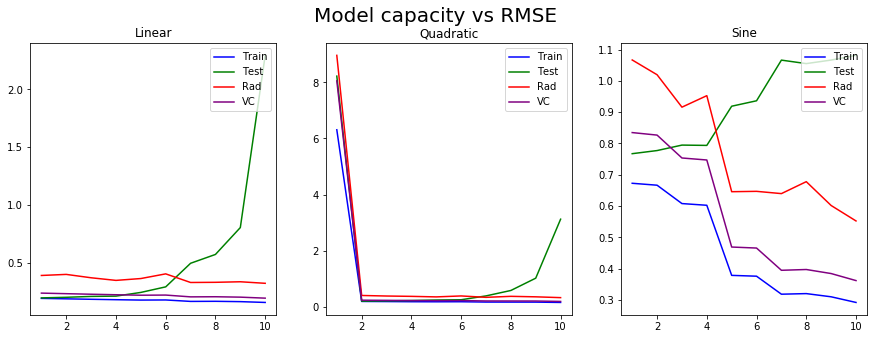

In [75]:
#Step 3: Evaluation
import matplotlib.pyplot as plt

print("\nRMSE linear: ", test_errorp[0])
print("\nRMSE quadratic: ", test_errorp[1])
print("\nRMSE sine: ", test_errorp[2])

funcs = ["Linear", "Quadratic", "Sine"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle('Model capacity vs RMSE',fontsize=20)
for i in range(0,3):
    axes[i].set_title(funcs[i])
    axes[i].plot(pw,train_errorp[i],color='blue', label = 'Train')
    axes[i].plot(pw,test_errorp[i],color = 'green', label = 'Test')
    axes[i].plot(pw,radBoundp[i], color = 'red', label = 'Rad')
    axes[i].plot(pw,VCBoundp[i], color = 'purple', label = 'VC')
    axes[i].legend(loc='upper right')
plt.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[[0.19556675 0.20073471 0.20824262 0.21091043 0.24292764 0.29106455
  0.49514866 0.57158523 0.80416788 2.29451625]
 [8.22480455 0.19924534 0.20826001 0.21971396 0.23796134 0.24798472
  0.38515918 0.57900305 1.01763845 3.12141742]
 [0.76738806 0.77736309 0.79482524 0.79381834 0.91898442 0.93633065
  1.06618643 1.05506912 1.06638504 1.08141617]]


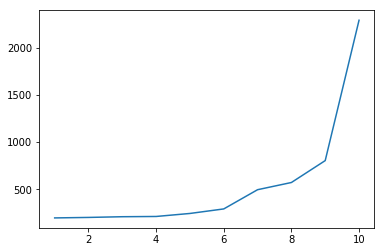

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.24      2.89677e+07       30          105.171          1073.98     32.28s
   1     3.83      2.99594e+06        5            194.7          198.965     24.03s
   2     2.38      3.00563e+14        9          316.723          1713.31     18.65s
   3     1.55      1.55253e+07        9          189.027          653.832     14.57s
   4     1.39           425016        3           326.15          2194.52     11.83s
   5     1.37           717074        5          193.113          213.245      9.48s
   6     1.37           190391       17          318.854          2190.75      6.97s
   7     1.39      2.87499e+06        7          351.734          2282.74      4.81s
   8     1.38            36132       17          341.344           2241.5  

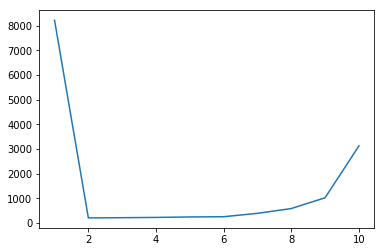

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    12.71      5.88395e+13        7          558.208           8224.8     30.82s
   1     3.93      7.39406e+06        4          612.841          8211.83     23.56s
   2     2.31       1.0215e+06        3          678.174          8222.09     17.92s
   3     1.47          17051.5        3          648.043           8223.8     14.36s
   4     1.38           472196        3          678.709           8222.8     12.12s
   5     1.38           416232       12          635.017          8224.17      9.25s
   6     1.35           546725        8          673.817          8222.02      6.72s
   7     1.41       1.6184e+06       22           612.01          8221.72      4.47s
   8     1.37           823613        3          648.043           8223.8  

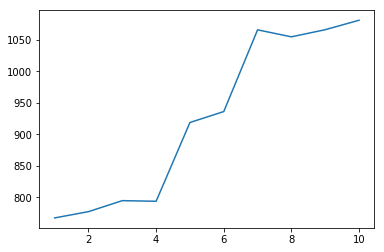

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


   0    12.44       1.0163e+09       42          315.581            330.4     29.94s
   1    30.25      1.17326e+08       21          199.256          374.093     48.00s
   2    10.45      3.93187e+06       21          464.166          326.665     26.07s
   3     2.40      1.22301e+06        4          404.818          677.629     15.99s
   4     1.42      1.10205e+06        3          310.414          137.481     11.89s
   5     1.42           856396       23          621.733          601.652      9.75s
   6     1.35           939226        4          864.118          1020.13      6.77s
   7     1.40           432944        6          846.531          868.984      4.90s
   8     1.40           839001        6          784.876          681.087      2.35s
   9     1.38           549345        8          832.334           964.02      0.00s
abs(div(add(X0, X0), div(-0.959, X0)))


In [79]:
#Step 4: Symbolic Regression 
f_set = function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt',  'abs', 'neg', 'inv', xexp]
est_gp = SymbolicRegressor(population_size=4000,
                           tournament_size = 10, generations=10, 
                           stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient='auto', random_state=None,
                           function_set = f_set)

power = []
for i in pw: 
    power.append(i)  
print(power)
power = np.array([power])
print(test_errorp)
for i in range(0,3):
    plt.plot(power.reshape(-1,1),1000*test_errorp[i])
    plt.show()
    est_gp.fit(power.reshape(-1,1), 1000*test_errorp[i])
    print(est_gp._program)

MSE (test_error x symbolic regressor)
Linear
0.01863518059934565
Quadratic
7.561239028119512
Sin
0.013949449777955097


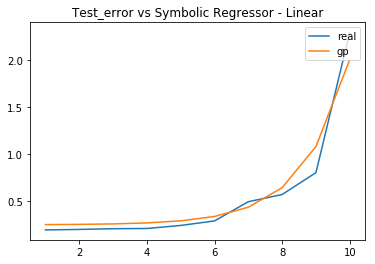

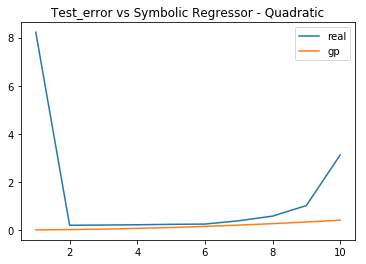

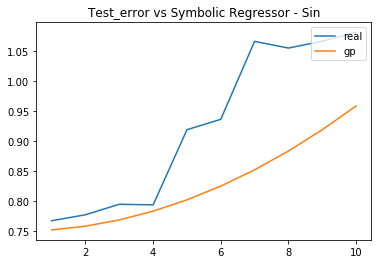

In [108]:
#Step 5: Evaluation for Symbolic Regressor
print("MSE (test_error x symbolic regressor)")

print("Linear")
y1=  (np.exp(abs(np.array(pw))*np.sqrt(0.558)))+250
print(mean_squared_error(test_errorp[0], y1/1000))

print("Quadratic")
y2=  (np.array(pw) + 0.393)*(np.array(pw)/0.253)
print(mean_squared_error(test_errorp[1], y2/1000))

#abs(div(add(X0, X0), div(-0.959, X0)))
print("Sin")
y3=  np.abs(2*np.array(pw)**2/(-0.959))+750
print(mean_squared_error(test_errorp[2], y3/1000))

plt.title("Test_error vs Symbolic Regressor - Linear")
plt.plot(np.array(pw), test_errorp[0], label = 'real')
plt.plot(np.array(pw), y1/1000, label = "gp")
plt.legend(loc = 'upper right')
plt.show()

plt.title("Test_error vs Symbolic Regressor - Quadratic")
plt.plot(np.array(pw), test_errorp[1], label = 'real')
plt.plot(np.array(pw), y2/1000, label = "gp")
plt.legend(loc = 'upper right')
plt.show()

plt.title("Test_error vs Symbolic Regressor - Sin")
plt.plot(np.array(pw), test_errorp[2], label = 'real')
plt.plot(np.array(pw), y3/1000, label = "gp")
plt.legend(loc = 'upper right')
plt.show()

### Conclusions experiment 2: 

**Theoretical expectations for Empirical Error Estimation:**
<br>Train error curve should decrease until irreducible error. (ok)
<br>Test error curve should present U-shape (error decreses and then increases with model capacity.The more capacity the lower the bias; the less the bias the better the ability to fit data well, which increases variance).The U-shape is observed only in the quadratic data (once polinomials of power 2 are added, increasing capacity have increased test error). 
<br>Theoretical bounds do not approximate test_error as well as in the experiments with increasing sample size. The Rademacher Constant and the VC Dimension should capture the depedency of the error with respect to model capacity, but these constants consistently underestimated test error in the experiments. They do not follow the theoretical U-shape and are much more biased towards train error. 

**Symbolic Regression Results:**
<br>Symbolic regression fails to find unique function that relates model capacity and test error. This is expected as we found different empirical test error curves for the different functions. The closed form found for each dataset:

Linear:
<br> $$ (e^{(|pw|*a1)}+a2) $$
<br>Quadratic: 
<br> $$ (pw + b1)*(pw/b2)$$
<br>Sin: 
<br> $$ |c1*pw^2/c2| $$

Where a1, a2, b1, b2, c1 and c2 are constants and pw is model capacity.


## Experiment 3:  Evaluating how train and test error varies by changing model capacity and sample size at the same time
Empirical train and test error: Root Mean Squared Error 
<br>Theoretical Bounds: Rademacher and VC Bounds for Regression 

Hyperparameters: 
<br>True Y is a polynomial degree 6 with additive noise from normal distribution(std = 0.2)
<br>Test Samples = 30
<br>Train Samples = [6,8,12...50]
<br>Varying model capacity by adding polynomials with degrees = [1,2,3...,6]
<br>Run each polynomial 100 times and take the average for calculating the empirical erros to reduce noise. 

In [155]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import numpy as np

n = range(6,50, 4)
n_2 = range(0,100,1)
pw = range(1,7,1)
test_error = np.zeros([len(pw),len(n)])
train_error = np.zeros([len(pw),len(n)])
Rad = np.zeros([len(pw),len(n)])
temp = []
temp2= []
temp_train = []
temp2_train = []
temp_L = []
temp_L2 = []


X_test = np.random.uniform(0,1,30).reshape(-1,1)
e = np.random.normal(0,0.2,30).reshape(-1,1)
Y_test = (10.5*X_test + 30*X_test**2 + 40*X_test**3 + 12*X_test**4 + 15*X_test**5+ 55*X_test**6 + e).reshape(-1,1)

for counter,value in enumerate(n): 
    print("Sample ", str(value))
    for i in pw:
        print("Power ", str(i))
        for j in n_2:
            #step 1 - data generation        
            X_train = np.random.uniform(0,1,value).reshape(-1,1)
            e = np.random.normal(0,0.2,value).reshape(-1,1)
            #true function
            Y_train = (10.5*X_train + 30*X_train**2 + 40*X_train**3 + 12*X_train**4 + 15*X_train**5 + 55*X_train**6 + e).reshape(-1,1) 
            
            #creating polynomialfeatures
            poly = PolynomialFeatures(degree = i) 
            X_train_poly = poly.fit_transform(X_train) 
            X_test_poly = poly.fit_transform(X_test) 

            #rademacher sigma
            s = rademacher_variables(len(Y_train))
            
            #step 2 - model training
            #initialisation of linear regression 
            m = LinearRegression()

            #inserting train data in model for training
            m.fit(X_train_poly,Y_train)

            #predicting values for test data
            Y_pred = m.predict(X_test_poly)
            Y_pred_train = m.predict(X_train_poly)

            #computing RMSE for train and test
            error = np.sqrt(mean_squared_error(Y_test, Y_pred))
            temp.append(error) 
            error_train = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
            temp_train.append(error_train)
            
            #computing Rademacher constant
            L = (2*np.dot(s, np.sqrt((Y_train-Y_pred_train)**2)))/len(Y_train)
            temp_L.append(L)


        temp2.append(sum(temp) / len(temp))
        temp2_train.append(sum(temp_train)/len(temp_train))
        temp_L2.append(max(temp_L))
        temp.clear()
        temp_train.clear()
        temp_L.clear()
    test_error[:,counter] = temp2
    train_error[:,counter] = temp2_train
    Rad[:,counter] = temp_L2
    temp2.clear()
    temp2_train.clear()
    temp_L2.clear()

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound(len(pw), len(n), np.array(n), 0.1, train_error, Rad)
print("Rademacher Bound")
print(radBound)
VCdim = vc_dimension_regression(len(pw), len(n), np.array(n), Rad)
print("VC Dimension")
print(VCdim)
VCBound = VC_bound(len(pw), len(n), np.array(n), train_error, VCdim, 0.1)
print("VC Bound")
print(VCBound)


Sample  6
Power  1
Power  2
Power  3
Power  4
Power  5
Power  6
Sample  10
Power  1
Power  2
Power  3
Power  4
Power  5
Power  6
Sample  14
Power  1
Power  2
Power  3
Power  4
Power  5
Power  6
Sample  18
Power  1
Power  2
Power  3
Power  4
Power  5
Power  6
Sample  22
Power  1
Power  2
Power  3
Power  4
Power  5
Power  6
Sample  26
Power  1
Power  2
Power  3
Power  4
Power  5
Power  6
Sample  30
Power  1
Power  2
Power  3
Power  4
Power  5
Power  6
Sample  34
Power  1
Power  2
Power  3
Power  4
Power  5
Power  6
Sample  38
Power  1
Power  2
Power  3
Power  4
Power  5
Power  6
Sample  42
Power  1
Power  2
Power  3
Power  4
Power  5
Power  6
Sample  46
Power  1
Power  2
Power  3
Power  4
Power  5
Power  6
Rademacher Constant
[[1.79290582e+01 1.31778412e+01 1.31502806e+01 1.09133159e+01
  1.01217964e+01 9.46217623e+00 1.23859701e+01 7.52964762e+00
  1.03327914e+01 6.85750386e+00 6.29901252e+00]
 [4.47084185e+00 3.42999158e+00 2.99301859e+00 2.53457158e+00
  3.01223243e+00 3.47697154e+00 

Min RMSE:  0.2399162688912076
Position of min RMSE:  (array([5], dtype=int64), array([10], dtype=int64))
[1, 2, 3, 4, 5, 6]
[6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46]

Min RMSE for each polynomial 
[21.71834599  7.2665646   1.6545791   0.40485316  0.24070525  0.23991627]


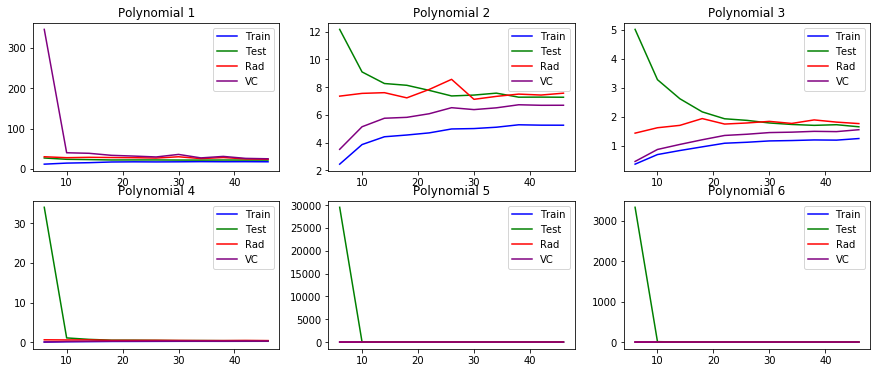

In [156]:
#Step 3: evaluation

import matplotlib.pyplot as plt

print("Min RMSE: ", np.amin(test_error))
pos = np.where(test_error== np.amin(test_error))
print('Position of min RMSE: ', pos)
print(list(pw))
print(list(n))

print('\nMin RMSE for each polynomial ')
print(np.amin(test_error, axis = 1))

#plotting
fig, axs = plt.subplots(2,3, figsize=(15, 6))
axs = axs.flatten()
for i in pw:
    axs[i-1].plot(n, train_error[i-1,:], color = 'blue', label = 'Train')
    axs[i-1].plot(n, test_error[i-1,:], color = 'green', label = 'Test')
    axs[i-1].plot(n, radBound[i-1], color = 'red', label = 'Rad')
    axs[i-1].plot(n,VCBound[i-1], color = 'purple', label = 'VC')
    axs[i-1].legend(loc='upper right')
    axs[i-1].set_title("Polynomial %d" %i)
plt.show()


In [159]:
#Step 4: Symbolic Regression
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

# Create custom operations (exp) to be considered in the tree
def xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a 

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add','mul', 'div', 'log', 'sqrt', 'neg', xexp]
est_gp = SymbolicRegressor(population_size=5000, metric = 'rmse',
                           generations=50, stopping_criteria=500,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=10, random_state=0,
                           function_set = f_set)
power = []
samples = []
for i in pw: 
    power.append(i)  
for i in n: 
    samples.append(i)  

a = np.transpose([ np.repeat(samples, len(power)), np.tile(power, len(samples))])
error = np.array(list(test_error.flatten()))
est_gp.fit(a,100*error)
print(est_gp._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.93       3.6406e+24       21          1015.48      1.12218e+06      1.72m
   1     8.40      4.57514e+08       13          969.829      1.12218e+06      1.99m
   2     6.37      2.20984e+08        4          995.178      1.12218e+06      1.63m
   3     5.17      7.90097e+16        2           1007.7      1.12217e+06      1.45m
   4     4.83      2.01737e+17        5          983.854      1.12218e+06      1.57m
   5     5.04      1.09143e+16        3          968.606      1.12218e+06      2.81m
   6     4.83      9.35861e+15        3           1007.4      1.12218e+06      2.73m
   7     4.70      4.87351e+09        3           963.98      1.12218e+06      2.58m
   8     4.77       1.4096e+14        2          976.164      1.12218e+06  

c:\users\gabi\miniconda3\lib\site-packages\gplearn\functions.py:127: RuntimeWarning: overflow encountered in true_divide
  return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


  49    13.70      1.93057e+15        2          1013.94      1.12218e+06      0.00s
sqrt(X0)


### Conclusions experiment 3: 
**Empirical Error Estimation Results:**
<br>Polynomial with degree 5 and 6 aproximates the true Y with low number of samples (~10). When the capacity is small (polynomial 1,2 and 3), train and test curves show similar behavior as in the experiments in 1 (varying only sample size).
<br>Theoretical bounds do not approximate test_error as well as in the experiments with increasing sample size. As model capacity increases, the theoretical bounds become less predictive of the experimental test error.

**Symbolic Regression Results:**
<br>Symbolic regression fails to find a meaningful function for this experiment. 